## Bagged vs SmartBagged Regression with Hidden Observations

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import average_precision_score

from matplotlib.colors import ListedColormap

(5000, 2)
(5000,)


<AxesSubplot:>

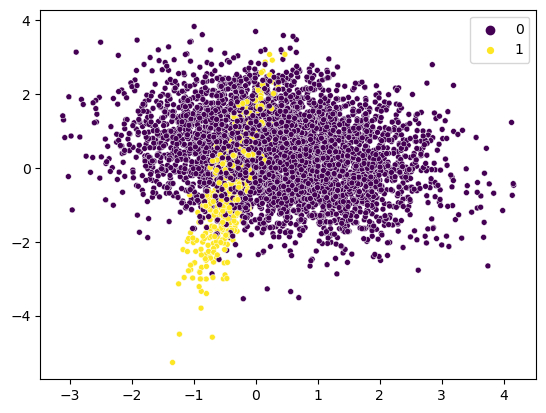

In [2]:
## creo dataset
rng = np.random.RandomState(123)
X, y = make_classification(n_samples=5000
                       ,n_features=2
                       ,n_informative=2
                       ,n_redundant=0
                       ,n_repeated=0 
                       ,n_classes=2
                       ,n_clusters_per_class=1
                       ,weights=[0.90, 0.10]
                       ,flip_y=0
                       ,class_sep=0.4
                       ,random_state=rng)
print(X.shape)
print(y.shape)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, size=1, palette=['#440154FF','#FDE725FF'])

### 0. Escondo algunas observaciones que originalmente eran y=1 (Hidden)

<AxesSubplot:>

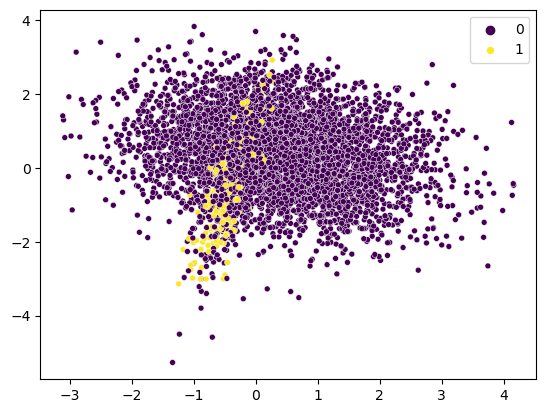

In [3]:
X_seed = X[y==1,:]
X_poblacion = X[y==0,:]
contamination = 0.5
idx_hidden = rng.choice(np.argwhere(y == 1).ravel()
                        ,size=int(X_seed.shape[0]*contamination)
                        ,replace=False)
y[idx_hidden]=0
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, size=1, palette=['#440154FF','#FDE725FF'])

In [4]:
print(len(y))
print(len(y[y==1]))
print(len(y[y==0]))

5000
250
4750


### 1. Modelo de Clasificacion Clasico

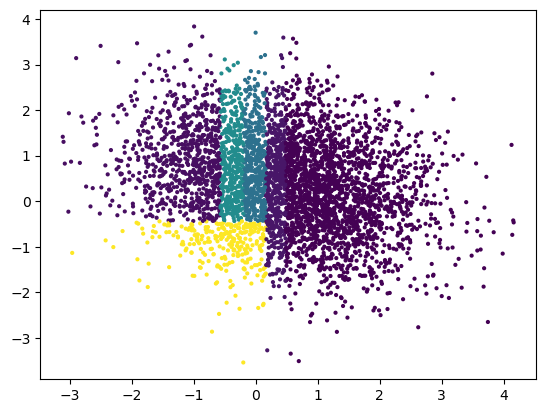

In [16]:
### Classification Model and predictions

# classifier
clf = 'tree'
# classifier param
# kwargs_clf = {'penalty': 'none'}
kwargs_clf = {'min_samples_leaf': 0.1}
# kwargs_clf = {'n_neighbors': 5}
##################

# color map
cm = plt.cm.viridis
cm_bright = ListedColormap(['#440154FF','#FDE725FF'])

# train
if clf=='rf':
    mod = RandomForestClassifier(random_state=rng, **kwargs_clf)
elif clf=='logistic':
    mod = LogisticRegression(random_state=rng, **kwargs_clf)
elif clf=='tree':
    mod = DecisionTreeClassifier(random_state=rng, **kwargs_clf)
elif cf=='knn':
    mod = KNNeighborsClassifier(**kwargs_clf)
mod.fit(X, y)
    
# predict poblacion
pred = mod.predict_proba(X_poblacion)[:,mod.classes_ == 1].ravel()
# predict y=0 and hiddens
predh = mod.predict_proba(X[y==0,:])[:, mod.classes_ == 1].ravel()

plt.scatter(X_poblacion[:,0], X_poblacion[:,1], c=pred, cmap=cm, s=4)

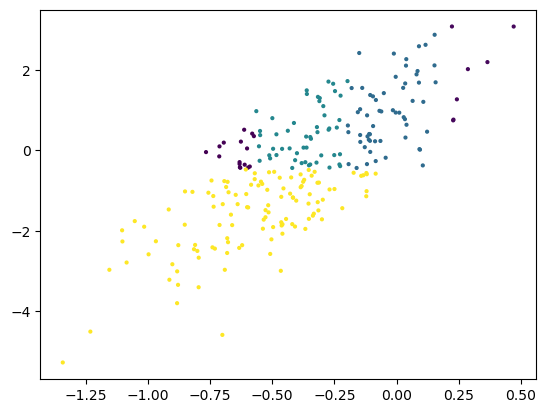

In [17]:
# predict hidden
pred_hidden = mod.predict_proba(X[idx_hidden, :])[:, mod.classes_ == 1].ravel()
plt.scatter(X[idx_hidden,0], X[idx_hidden,1], c=pred_hidden, cmap=cm, s=4)

In [18]:
# average precision
y_true = y.copy()
y_true[idx_hidden] = 1
y_true = y_true[y == 0]
average_precision_score(y_true, predh)

0.23302336823020117

### 2. Bagged and SmartBagged Models

In [20]:
def smartbagged_clf(X_seed, X_poblacion, random_state, T=50, clf='logistic', l1=1, l2=1, **kwargs_clf):
    """
    Returns avg of oob predictions of classifier para la poblacion
    Param:
        - T number of baggint iteractions 
        - clf: base estimator (one of rg, logistic)
    """
    # K: size of boostrap sample (= size of seed)
    K = X_seed.shape[0]
    # U: size of poblation
    U = X_poblacion.shape[0]
    # se entrena con una muestra balanceada
    # vector target: primero seed - luego poblacion
    y_train = np.concatenate([np.ones(K), np.zeros(K)])
    # initialize numerador de predicciones
    pred = np.zeros(U)
    # initialize denominador de predicciones
    n = np.zeros(U)
    # iniialize weight vectors
    w_poblacion = np.ones(U)
    w_seed = np.ones(K)

    # bagging
    for t in range(T):
        # get sample
        idx_train = np.random.choice(U, K, replace=True)
        X_train = np.concatenate([X_seed, X_poblacion.iloc[idx_train,:]])
        # weights
        # print(w_poblacion[idx_train], "/n")
        weights = np.concatenate([w_seed, w_poblacion[idx_train]])      
        # train
        if clf=='rf':
            clf = RandomForestClassifier(**kwargs_clf)
        if clf=='logistic':
            clf = LogisticRegression(**kwargs_clf)
        if clf=='tree':
            clf = DecisionTreeClassifier(**kwargs_clf)
        if clf=='knn':
            clf = KNeighborsClassifier(**kwargs_clf)
        clf.fit(X_train, y_train, sample_weight = weights)
        # predict OOB
        idx_oob = np.full(U, True)
        idx_oob[idx_train] = False
        _pred = clf.predict_proba(X_poblacion.iloc[idx_oob,:])[:,clf.classes_ == 1].ravel()
        pred[idx_oob] += _pred
        n[idx_oob] += 1
        # update weight vector
        if t > (T*l1):
            _wupdate = np.zeros(U)
            _wupdate[idx_oob] = _pred
            w_poblacion += (-_wupdate/T*l2) 
    scores = pred / n
    return scores

In [65]:
pclf='tree'
pkwargs_clf = {'min_samples_leaf': 5}

#### 2.1 Bagged Model

0.3471156221851704

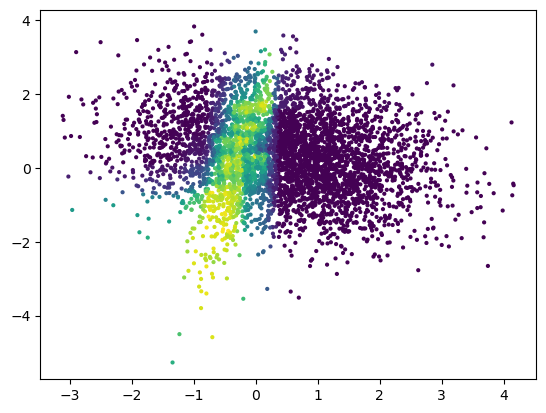

In [66]:
# predict bagged
pred_bagged = smartbagged_clf(pd.DataFrame(X[y==1, :]), pd.DataFrame(X[y==0, :]),
                         random_state = 42, T=50, clf=pclf, l1=1, l2=1, **pkwargs_clf)

# predict poblacion
plt.scatter(X[y==0,0], X[y==0,1], c=pred_bagged, cmap=cm, s=4)

# average precision
average_precision_score(y_true, pred_bagged)

#### 2.2 SmartBagged Model

0.3738406383758845

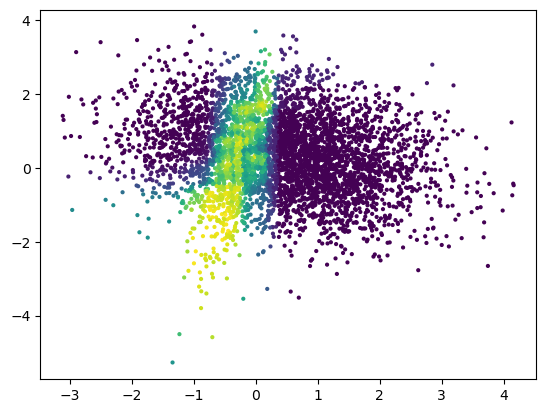

In [67]:
# predict bagged
pred_sbagged = smartbagged_clf(pd.DataFrame(X[y==1, :]), pd.DataFrame(X[y==0, :]),
                         random_state = 42, T=100, clf=pclf, l1=0.1, l2=0.5, **pkwargs_clf)

# predict poblacion
plt.scatter(X[y==0,0], X[y==0,1], c=pred_sbagged, cmap=cm, s=4)

# average precision
average_precision_score(y_true, pred_sbagged)